# Predicción de ACVs

Un accidente cerebrovascular (ACV) ocurre cuando se detiene el flujo sanguíneo a alguna parte del cerebro y que, según su duración, puede causar daños irreversibles o incluso la muerte. Se calcula que cada año aproximadamente 15 millones de personas sufren un ACV ([M.E. Clément et al.,  2017](https://www.elsevier.es/es-revista-neurologia-argentina-301-articulo-incidencia-enfermedad-cerebrovascular-adultos-estudio-S1853002817300721)). De estos últimos alrededor de 5 millones mueren y otros 5 millones quedan con discapacidad severa. La Organización Mundial de la Salud estima que cada 5 segundos ocurre un ACV en la población mundial.

Hay diversos factores que contribuyen al riesgo de un ACV, como ser: la presión arterial alta, la diabetes, la obesidad, el tabaquismo y el colesterol alto, entre otros ([CDC, 2017](https://www.cdc.gov/spanish/signosvitales/accidentes-cerebrovasculares/index.html#:~:text=Cada%20a%C3%B1o%2C%20casi%20800%20000,los%20accidentes%20cerebrovasculares%20son%20prevenibles.)). El presente trabajo práctico tiene como objetivo la aplicación de técnicas de Aprendizaje Automático para predecir la ocurrencia de un ACV a partir de diversos parámetros. Se trata de un problema de clasificación con dos resultados posibles: 1 para personas que sufrieron un ACV y 0 para aquellas que no.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, cross_val_score, HalvingRandomSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm, metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix, accuracy_score, classification_report
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.stats import randint, uniform

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Preparación y Exploración de los datos

In [ ]:
bs = '/content/drive/MyDrive/TP SAT1/Brain Stroke/Brain Stroke dataset.csv'
df = pd.read_csv(bs)

## Análisis de la base de datos

En primer lugar, se utilizan diversas funciones de la biblioteca Pandas para obtener una visión general del data frame.

In [ ]:
#Vemos como es el data frame
df.head(10)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
5,Male,74.0,1,1,Yes,Private,Rural,70.09,27.4,never smoked,1
6,Female,69.0,0,0,No,Private,Urban,94.39,22.8,never smoked,1
7,Female,78.0,0,0,Yes,Private,Urban,58.57,24.2,Unknown,1
8,Female,81.0,1,0,Yes,Private,Rural,80.43,29.7,never smoked,1
9,Female,61.0,0,1,Yes,Govt_job,Rural,120.46,36.8,smokes,1


Se puede observar en el output del método .info() que la base de datos tiene 4981 entradas y cada uno de los distintos parámetros tiene 4981 valores no nulos. En principio, parecería que la base de datos no cuenta con valores faltantes.





In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4981 entries, 0 to 4980
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4981 non-null   object 
 1   age                4981 non-null   float64
 2   hypertension       4981 non-null   int64  
 3   heart_disease      4981 non-null   int64  
 4   ever_married       4981 non-null   object 
 5   work_type          4981 non-null   object 
 6   Residence_type     4981 non-null   object 
 7   avg_glucose_level  4981 non-null   float64
 8   bmi                4981 non-null   float64
 9   smoking_status     4981 non-null   object 
 10  stroke             4981 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 428.2+ KB


Luego, con el método .describe() pueden verse algunos valores estadísticos y parámetros de interés.


In [ ]:
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000
mean,43.419859,0.096165,0.055210,105.943562,28.498173,0.049789
std,22.662755,0.294848,0.228412,45.075373,6.790464,0.217531
min,0.080000,0.000000,0.000000,55.120000,14.000000,0.000000
25%,25.000000,0.000000,0.000000,77.230000,23.700000,0.000000
50%,45.000000,0.000000,0.000000,91.850000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,113.860000,32.600000,0.000000
max,82.000000,1.000000,1.000000,271.740000,48.900000,1.000000


Si bien la base de datos no tiene registros incompletos, con el método .unique() se puede observar que el campo *smoking_status* tiene registros con valor *Unknown*, es decir: Desconocido. Se evaluará más adelante el curso de acción para el tratamiento de dichos datos.

In [ ]:
#chequeo que son los datos no numéricos (salvo 1s y 0s)
indices = list(df.columns)
for i in range(len(indices)):
  a = pd.unique(df.loc[:, str(indices[i])])
  if(isinstance(a[0], float) == False):
    print(a)

['Male' 'Female']
[0 1]
[1 0]
['Yes' 'No']
['Private' 'Self-employed' 'Govt_job' 'children']
['Urban' 'Rural']
['formerly smoked' 'never smoked' 'smokes' 'Unknown']
[1 0]


In [ ]:
df.sort_values('age', ascending = True)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
3057,Male,0.08,0,0,No,children,Rural,70.33,16.9,Unknown,0
1487,Female,0.08,0,0,No,children,Urban,139.67,14.1,Unknown,0
3363,Male,0.16,0,0,No,children,Urban,114.71,17.4,Unknown,0
3996,Male,0.24,0,0,No,children,Urban,57.09,19.4,Unknown,0
3148,Male,0.24,0,0,No,children,Urban,89.28,14.2,Unknown,0
...,...,...,...,...,...,...,...,...,...,...,...
4503,Female,82.00,0,0,Yes,Self-employed,Urban,113.45,30.3,never smoked,0
116,Male,82.00,0,1,Yes,Govt_job,Rural,103.68,25.0,never smoked,1
2163,Female,82.00,0,0,Yes,Private,Urban,80.00,33.6,never smoked,0
2103,Female,82.00,0,0,Yes,Self-employed,Rural,117.75,29.8,never smoked,0


A continuación, se observa que hay 1500 valores *Unknown*, lo cual representa un 30% de los valores. De ser reemplazados de una forma no coherente podría implicar errores en el análisis futuro. 

Cabe destacar que alrededor del 40% de los valores *Unkown* corresponden a niños. Lo más probable es que para ellos la opción correcta sea *never smoked*.


In [ ]:
print('Cantidad de datos de los distintos valores de smoking_status: \n\n',df['smoking_status'].value_counts())
print('\nDistribución de entradas de trabajo segun Unknown smoking_status: \n\n',df[df['smoking_status'] == 'Unknown']['work_type'].value_counts())

Cantidad de datos de los distintos valores de smoking_status: 

 never smoked       1838
Unknown            1500
formerly smoked     867
smokes              776
Name: smoking_status, dtype: int64

Distribución de entradas de trabajo segun Unknown smoking_status: 

 Private          623
children         604
Self-employed    153
Govt_job         120
Name: work_type, dtype: int64


## Acondicionamiento de la base de datos

De los campos con valores no numéricos se deberá convertirlos, cuando sea posible, en valores binarios. Se busca de esta forma dividir las opciones en categorías que el programa pueda interpretar fácilmente.

Por lo tanto, se tomaron los siguientes parámetros:


*   Gender: Female = 1, Male = 0
*   Residence_type: Urban = 1, Rural = 0
*   ever_married: Yes = 1, No = 0
*   smoking_status: never smoked = -1, formerly smoked = 0, smokes = 1

In [ ]:
df = df.replace(to_replace=["Female", "Male"] ,value=[1, 0])
df = df.replace(to_replace=["Urban", "Rural"] ,value=[1, 0])
df = df.replace(to_replace=["Yes", "No"] ,value=[1, 0])
df = df.replace(to_replace=["never smoked", "formerly smoked", "smokes", "Unknown"] ,value=[-1, 0, 1, np.nan])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4981 entries, 0 to 4980
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4981 non-null   int64  
 1   age                4981 non-null   float64
 2   hypertension       4981 non-null   int64  
 3   heart_disease      4981 non-null   int64  
 4   ever_married       4981 non-null   int64  
 5   work_type          4981 non-null   object 
 6   Residence_type     4981 non-null   int64  
 7   avg_glucose_level  4981 non-null   float64
 8   bmi                4981 non-null   float64
 9   smoking_status     3481 non-null   float64
 10  stroke             4981 non-null   int64  
dtypes: float64(4), int64(6), object(1)
memory usage: 428.2+ KB


Se contabilizaron la cantidad de valores que había por cada opción del *smoking status*. Como puede observarse, la mayoría corresponde al -1, es decir, personas que nunca fumaron. Luego, se analizaron la moda, la mediana y la media para decidir por que valor reemplazar los *Unknown*.

Se observa que la moda y la mediana coinciden.

In [ ]:
print(df['smoking_status'].value_counts())

-1.0    1838
 0.0     867
 1.0     776
Name: smoking_status, dtype: int64


Mediana:  -1.0
Moda:  -1.0
Media:  -0.3050847457627119


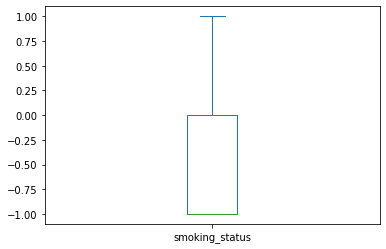

In [ ]:
df['smoking_status'].plot(kind='box')
print("Mediana: ",df.smoking_status.median(skipna=True))
print("Moda: ",df.smoking_status.mode(dropna=True)[0])
print("Media: ",df.smoking_status.mean(skipna=True))

Según lo analizado previamente, en particular teniendo en cuenta el gran porcentaje de niños, los valores mayoritarios y los parámetros estadísticos, se toma la decisión de reemplazar *Unknown* por -1.

In [ ]:
df1 = df.copy()
df1 = df1.fillna(-1)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4981 entries, 0 to 4980
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4981 non-null   int64  
 1   age                4981 non-null   float64
 2   hypertension       4981 non-null   int64  
 3   heart_disease      4981 non-null   int64  
 4   ever_married       4981 non-null   int64  
 5   work_type          4981 non-null   object 
 6   Residence_type     4981 non-null   int64  
 7   avg_glucose_level  4981 non-null   float64
 8   bmi                4981 non-null   float64
 9   smoking_status     4981 non-null   float64
 10  stroke             4981 non-null   int64  
dtypes: float64(4), int64(6), object(1)
memory usage: 428.2+ KB


A continuación, se crea una nueva columna que categoriza los pesos de las personas según su índice de masa corporal (BMI, por sus siglas en inglés).

In [ ]:
category = pd.cut(df1.bmi, bins=[0 ,18.5, 24.9, 39.9 ,49, 70], labels= ['underweight','healthy weight','overweight','obese 1','obese 2'])
df1.insert(9,'BMI ranges', category)
df1

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,BMI ranges,smoking_status,stroke
0,0,67.0,0,1,1,Private,1,228.69,36.6,overweight,0.0,1
1,0,80.0,0,1,1,Private,0,105.92,32.5,overweight,-1.0,1
2,1,49.0,0,0,1,Private,1,171.23,34.4,overweight,1.0,1
3,1,79.0,1,0,1,Self-employed,0,174.12,24.0,healthy weight,-1.0,1
4,0,81.0,0,0,1,Private,1,186.21,29.0,overweight,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
4976,0,41.0,0,0,0,Private,0,70.15,29.8,overweight,0.0,0
4977,0,40.0,0,0,1,Private,1,191.15,31.1,overweight,1.0,0
4978,1,45.0,1,0,1,Govt_job,0,95.02,31.8,overweight,1.0,0
4979,0,40.0,0,0,1,Private,0,83.94,30.0,overweight,1.0,0


Se observa luego que alrededor del 62% de las personas analizadas en el set de datos tienen sobrepeso y que ninguna alcanza la categoría de obesidad 2.

In [ ]:
df1['BMI ranges'].value_counts()

overweight        3093
healthy weight    1234
underweight        332
obese 1            322
obese 2              0
Name: BMI ranges, dtype: int64

Como puede observarse en el siguiente gráfico, el dataset se halla muy desbalanceado. En este caso, sólo alrededor del 5% representa un ACV, lo cual puede generar problemas en el posterior análisis.

0    4733
1     248
Name: stroke, dtype: int64


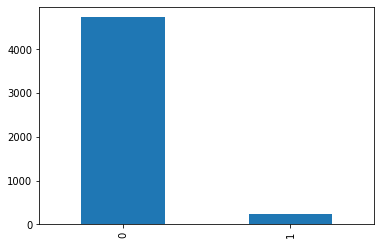

In [ ]:
df['stroke'].value_counts().plot(kind='bar')
print(df['stroke'].value_counts())

Como último paso del pre-procesamiento de los datos, estos fueron normalizados restando su media y dividiendo por su desvío estándar.

In [ ]:
#normalizacion
m1 = df.avg_glucose_level.mean()
std1 = df.avg_glucose_level.std()
df1['avg_glucose_level'] = (df1['avg_glucose_level'] - m1) / std1

m2 = df.age.mean()
std2 = df.age.std()
df1['age'] = (df1['age'] - m2) / std2

m3 = df.bmi.mean()
std3= df.bmi.std()
df1['bmi'] = (df1['bmi'] - m3) / std3

df1.head(10)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,BMI ranges,smoking_status,stroke
0,0,1.040480,0,1,1,Private,1,2.723138,1.193118,overweight,0.0,1
1,0,1.614108,0,1,1,Private,0,-0.000523,0.589330,overweight,-1.0,1
2,1,0.246225,0,0,1,Private,1,1.448384,0.869135,overweight,1.0,1
3,1,1.569983,1,0,1,Self-employed,0,1.512499,-0.662425,healthy weight,-1.0,1
4,0,1.658234,0,0,1,Private,1,1.780716,0.073902,overweight,0.0,1
5,0,1.349357,1,1,1,Private,0,-0.795414,-0.161723,overweight,-1.0,1
6,1,1.128730,0,0,0,Private,1,-0.256316,-0.839143,healthy weight,-1.0,1
7,1,1.525858,0,0,1,Private,1,-1.050985,-0.632972,healthy weight,-1.0,1
8,1,1.658234,1,0,1,Private,0,-0.566020,0.176987,overweight,-1.0,1
9,1,0.775728,0,1,1,Govt_job,0,0.322048,1.222571,overweight,1.0,1


## Análisis del efecto de distintos parámetros
Previo a la configuración de los modelos predictivos es necesario evaluar la correlación de las diferentes variables del dataset con la variable de output. Se muestran a continuación el gráfico de pares y el *heatmap*, o mapa de calor. 

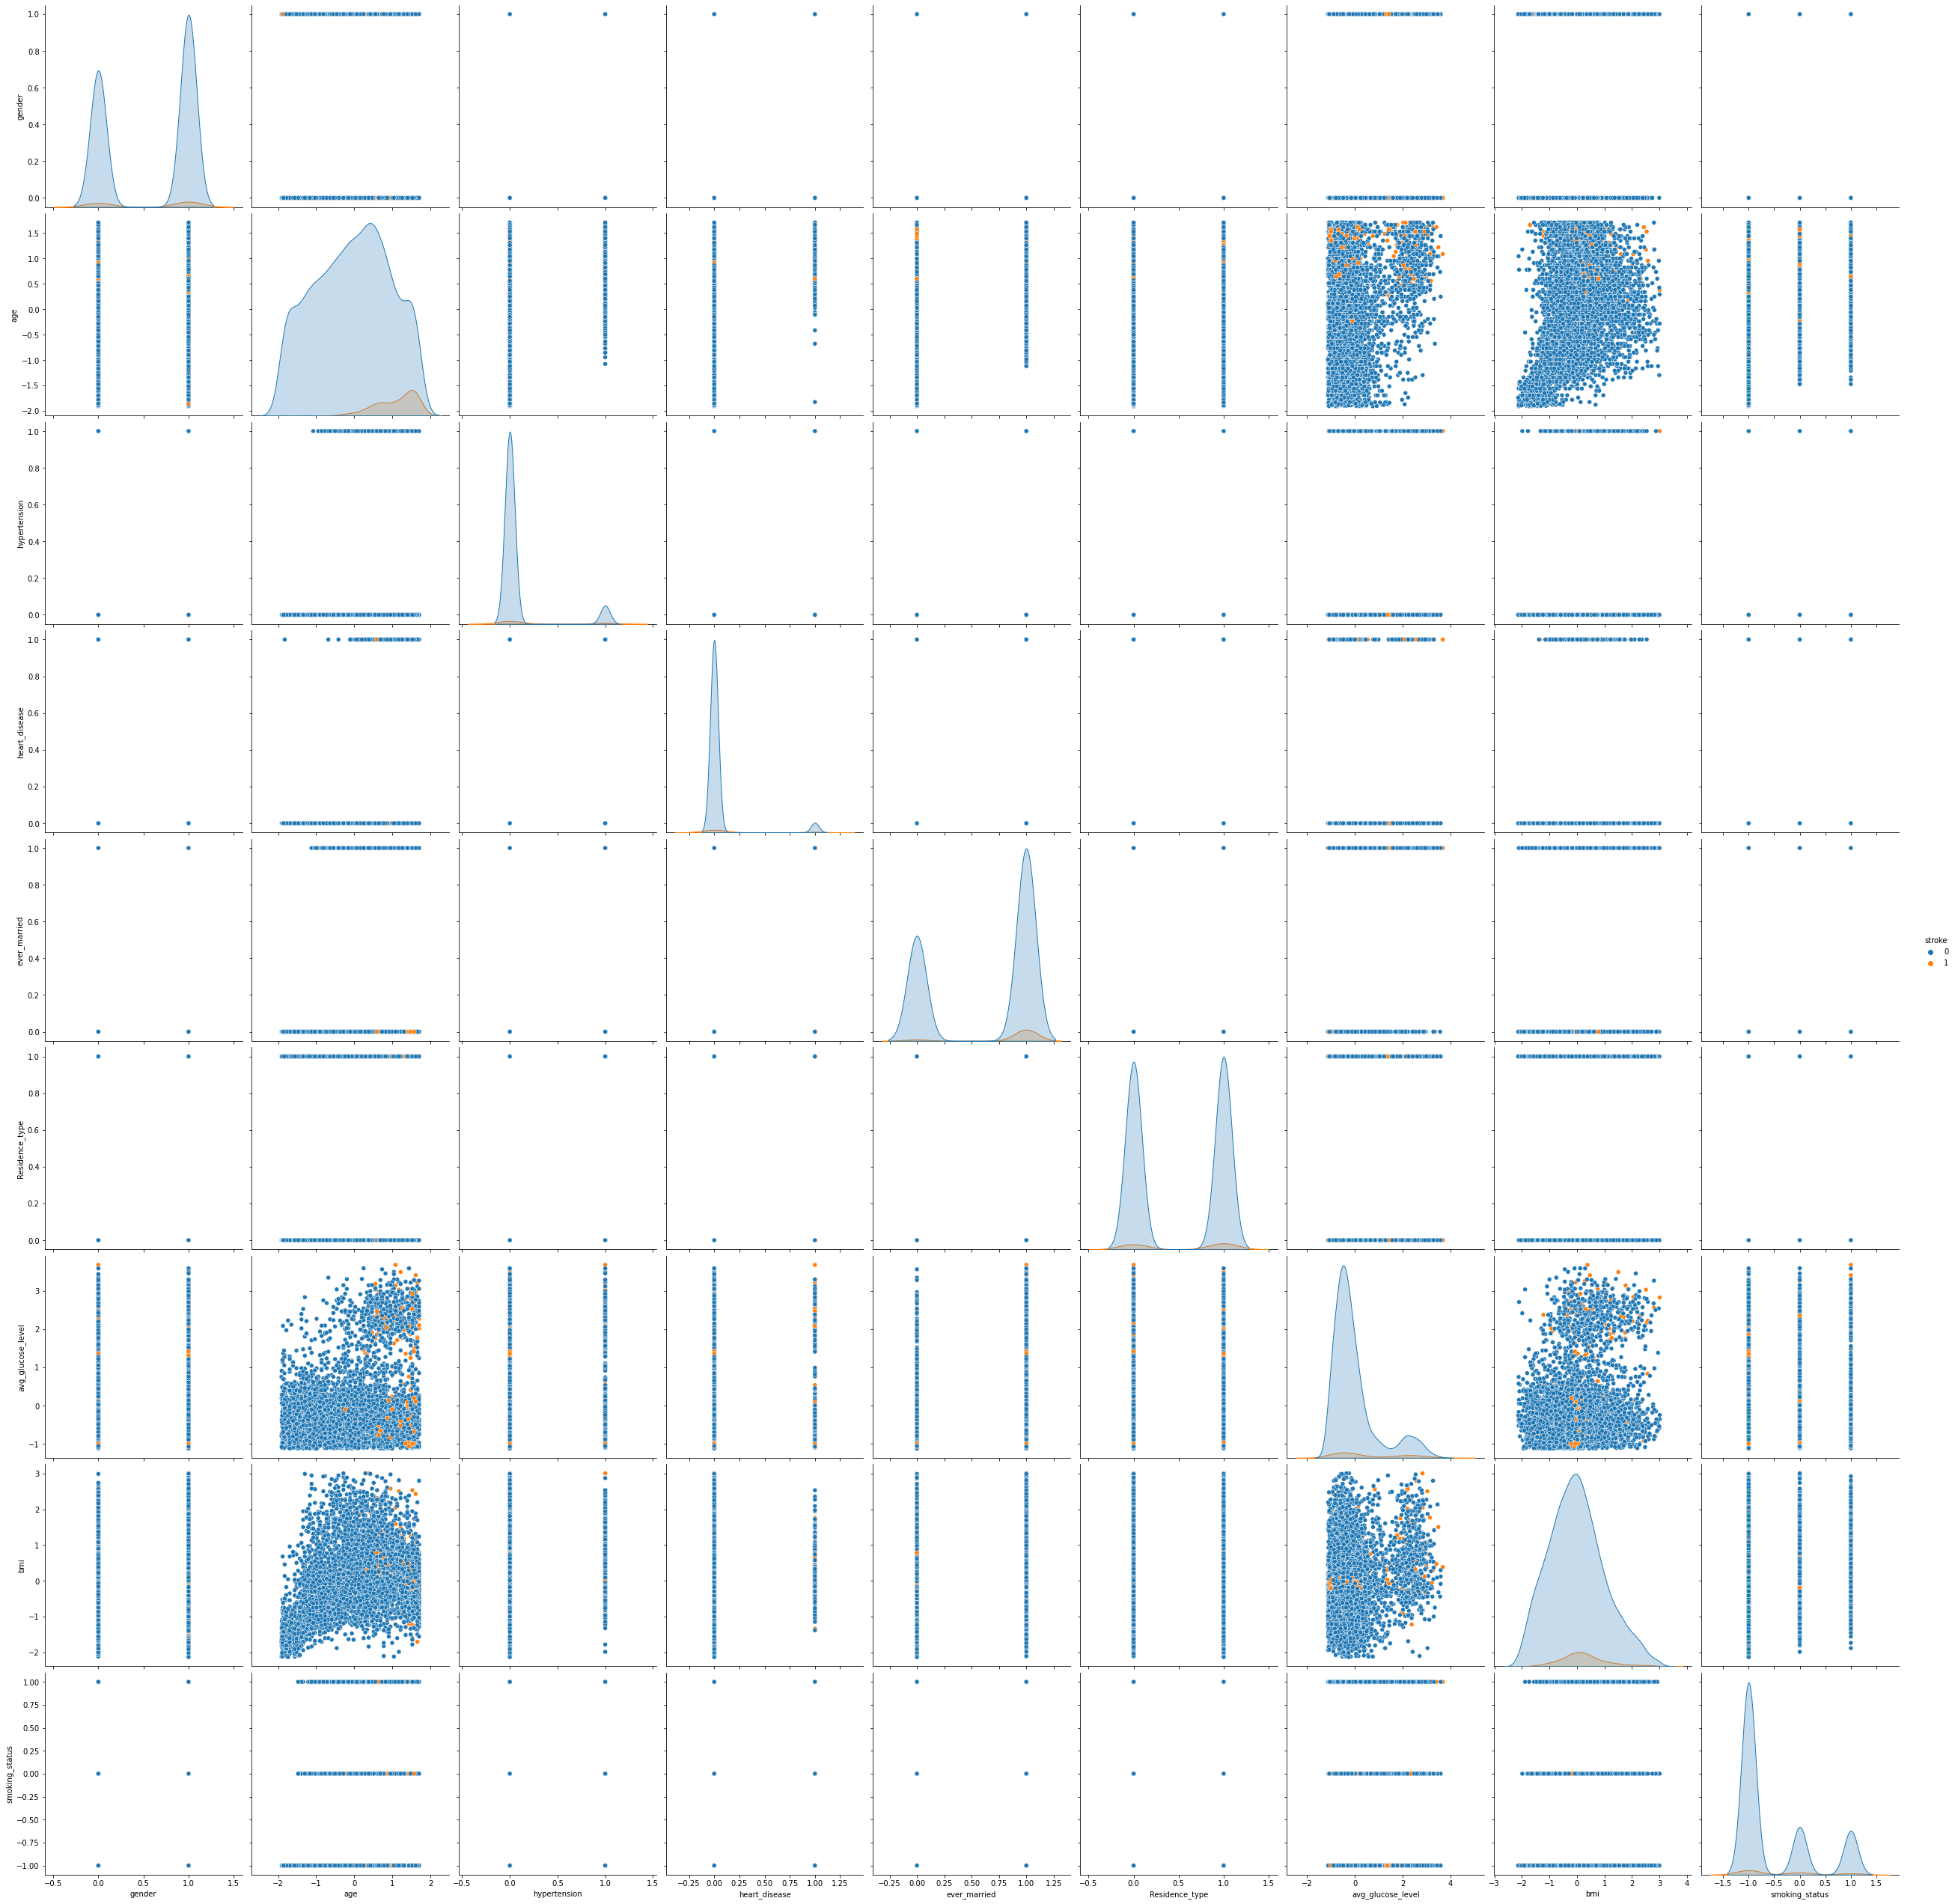

In [ ]:
sns.pairplot(df1, hue='stroke', height=4)

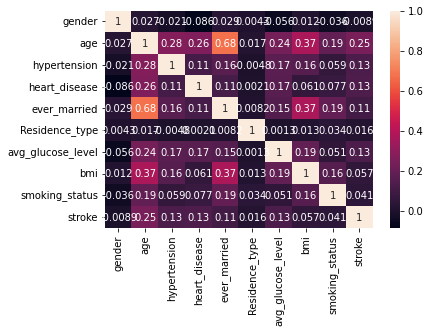

In [ ]:
sns.heatmap(df1.corr(method='pearson'), annot = True)

Los parámetros que más se correlacionan con la probabilidad de un accidente cerebrovascular son entonces:

*   En primer lugar, la edad (0,25)
*   Al mismo nivel: hipertensión, problemas cardíacos y BMI (0,13)
*   Por último, si alguna vez estuvieron casados (0,11)

Puede parecer raro que fumar acarree una correlación tan pequeña con la probabilidad de ACV, pero esto podría deberse a las características del dataset. En particular, se observa que solo el 5% representa ACVs, hay una gran cantidad de niños y además se reemplazó por "*never smoked*" todos los valores faltantes, como se explicó anteriormente.








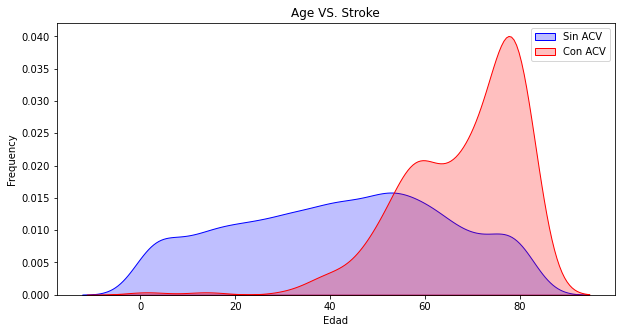

In [ ]:
fig = plt.figure(figsize=(10,5),)
ax=sns.kdeplot(df.loc[(df['stroke'] == 0),'age'] , color='b',shade=True, label='Sin ACV')
ax=sns.kdeplot(df.loc[(df['stroke'] == 1),'age'] , color='r',shade=True, label='Con ACV')
plt.legend()
ax.set(xlabel='Edad', ylabel='Frequency')
plt.title('Age VS. Stroke')
plt.show()

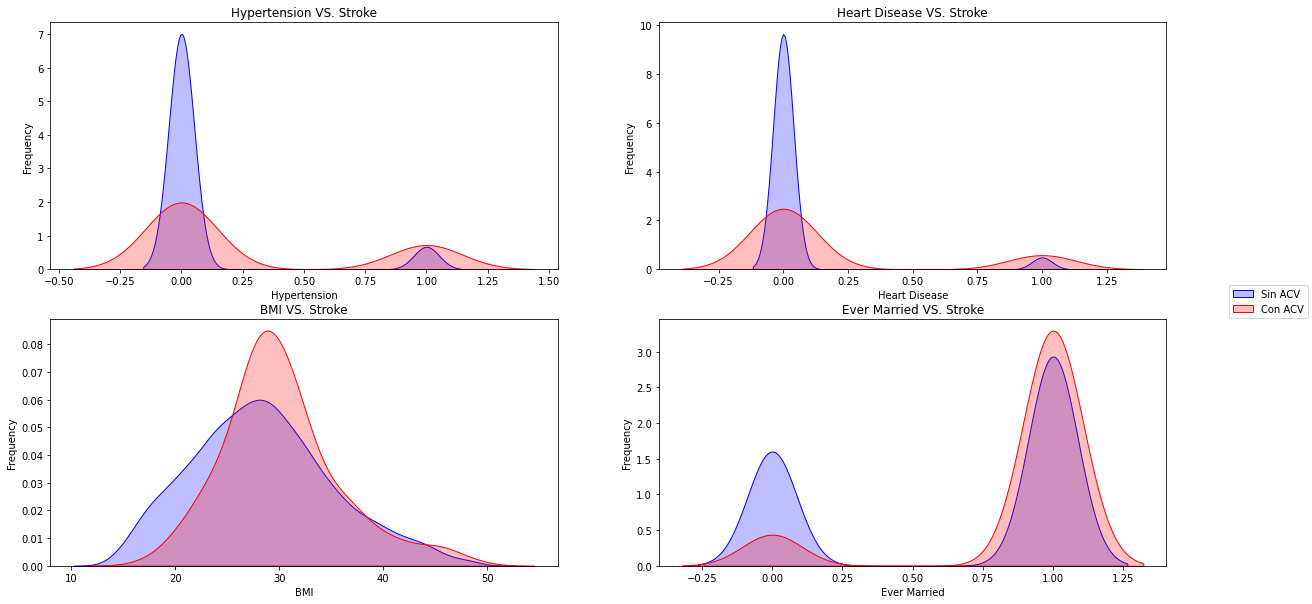

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,10))

sns.kdeplot(df.loc[(df['stroke'] == 0),'hypertension'] , color='b',shade=True, ax = axes[0][0])
sns.kdeplot(df.loc[(df['stroke'] == 1),'hypertension'] , color='r',shade=True, ax = axes[0][0])
axes[0][0].set_xlabel('Hypertension')
axes[0][0].set_ylabel('Frequency')
axes[0][0].set_title('Hypertension VS. Stroke')

sns.kdeplot(df.loc[(df['stroke'] == 0),'heart_disease'] , color='b',shade=True, ax = axes[0][1])
sns.kdeplot(df.loc[(df['stroke'] == 1),'heart_disease'] , color='r',shade=True, ax = axes[0][1])
axes[0][1].set_xlabel('Heart Disease')
axes[0][1].set_ylabel('Frequency')
axes[0][1].set_title('Heart Disease VS. Stroke')

sns.kdeplot(df.loc[(df['stroke'] == 0),'bmi'] , color='b',shade=True, ax = axes[1][0])
sns.kdeplot(df.loc[(df['stroke'] == 1),'bmi'] , color='r',shade=True, ax = axes[1][0])
axes[1][0].set_xlabel('BMI')
axes[1][0].set_ylabel('Frequency')
axes[1][0].set_title('BMI VS. Stroke')

sns.kdeplot(df.loc[(df['stroke'] == 0),'ever_married'] , color='b',shade=True, label='Sin ACV', ax = axes[1][1])
sns.kdeplot(df.loc[(df['stroke'] == 1),'ever_married'] , color='r',shade=True, label='Con ACV', ax = axes[1][1])
axes[1][1].set_xlabel('Ever Married')
axes[1][1].set_ylabel('Frequency')
axes[1][1].set_title('Ever Married VS. Stroke')

fig.legend(loc='center right')
plt.show()

# Modelos predictivos

## Primeros modelos predictivos

En principio, se divide en variables 'input' (hipertensión, BMI, etc.) y 'output' (presencia o ausencia de ACV). Luego, se generan los sets de testeo (que representa el 25% del total de los datos) y de entrenamiento (75%).

In [ ]:
#sets de testeo y entrenamiento

class_names = ['Sin ACV', 'Con ACV']

X = df1.copy()
y = X['stroke']

#elimino de X las columnas no numericas y el resultado 
del X['stroke']
del X['work_type']
del X['BMI ranges']

X = X.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

A continuación, se generan y se entrenan los modelos predictores según los algoritmos de *random forest*, k vecinos más cercanos y *support vector machine* (SVM).

In [ ]:
#genero los predictores

clf_kNN = KNeighborsClassifier()
clf_SVC = svm.SVC(random_state=0)
clf_RF = RandomForestClassifier(random_state=0)

In [ ]:
#entreno los algoritmos

clf_kNN.fit(X_train, y_train)
clf_SVC.fit(X_train, y_train)
clf_RF.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

## Análisis de resultados de los modelos
El parámetro de *accuracy* da una primera idea de que tan bien funciona un clasificador. En general, se puede ver que los valores de dicho parámetros son bastante cercanos a 1.


In [ ]:
y_pred_kNN = clf_kNN.predict(X_test)
y_pred_SVC = clf_SVC.predict(X_test)
y_pred_RF = clf_RF.predict(X_test)

acc_kNN = accuracy_score(y_test, y_pred_kNN)
acc_SVC = accuracy_score(y_test, y_pred_SVC)
acc_RF = accuracy_score(y_test, y_pred_RF)

In [ ]:
print('Accuracy score de kNN: %.4f' %(acc_kNN))
print('Accuracy score de SVM: %.4f' %(acc_SVC))
print('Accuracy score de Random Forest: %.4f' %(acc_RF))

Accuracy score de kNN: 0.9518
Accuracy score de SVM: 0.9526
Accuracy score de Random Forest: 0.9510


Luego, se generaron las matrices de confusión para cada modelo.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMa

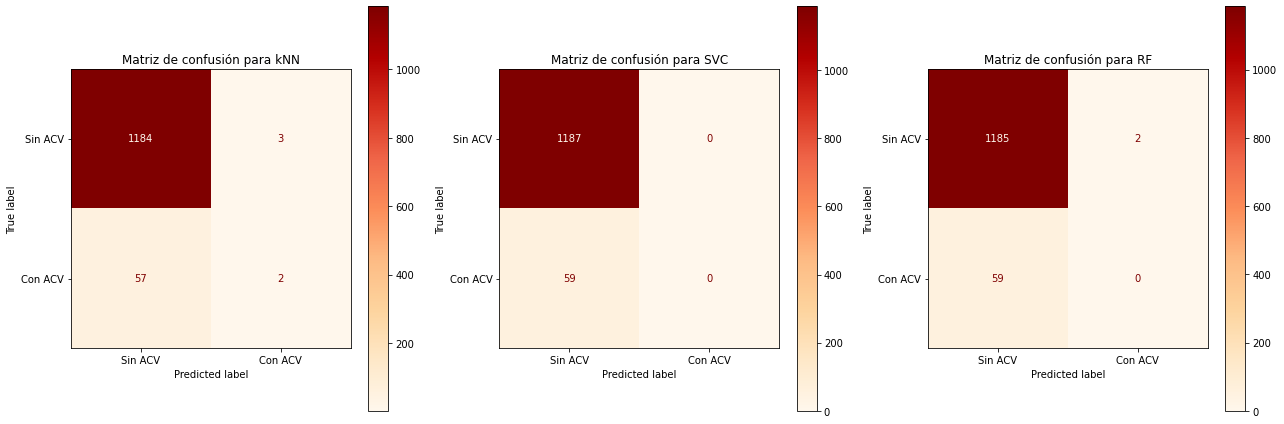

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18,6))

disp = plot_confusion_matrix(clf_kNN, X_test, y_test, display_labels=class_names,cmap = 'OrRd', ax=ax1)
disp.ax_.set_title("Matriz de confusión para kNN")

disp = plot_confusion_matrix(clf_SVC, X_test, y_test, display_labels=class_names, cmap = 'OrRd', ax=ax2)
disp.ax_.set_title("Matriz de confusión para SVC")

disp = plot_confusion_matrix(clf_RF, X_test, y_test, display_labels=class_names, cmap = 'OrRd', ax=ax3)
disp.ax_.set_title("Matriz de confusión para RF")

plt.tight_layout() 
plt.show()

In [ ]:
print('\n kNN REPORT')
print(classification_report(y_test, y_pred_kNN, target_names=class_names))
print('\n SVM REPORT')
print(classification_report(y_test, y_pred_SVC, target_names=class_names))
print('\n RANDOM FOREST REPORT')
print(classification_report(y_test, y_pred_RF, target_names=class_names))


 kNN REPORT
              precision    recall  f1-score   support

     Sin ACV       0.95      1.00      0.98      1187
     Con ACV       0.40      0.03      0.06        59

    accuracy                           0.95      1246
   macro avg       0.68      0.52      0.52      1246
weighted avg       0.93      0.95      0.93      1246


 SVM REPORT
              precision    recall  f1-score   support

     Sin ACV       0.95      1.00      0.98      1187
     Con ACV       0.00      0.00      0.00        59

    accuracy                           0.95      1246
   macro avg       0.48      0.50      0.49      1246
weighted avg       0.91      0.95      0.93      1246


 RANDOM FOREST REPORT
              precision    recall  f1-score   support

     Sin ACV       0.95      1.00      0.97      1187
     Con ACV       0.00      0.00      0.00        59

    accuracy                           0.95      1246
   macro avg       0.48      0.50      0.49      1246
weighted avg       0.91  

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Al hacer un análisis con mayor profundidad de los resultados, resulta evidente que los modelos no logran distinguir los casos de presencia de ACV. Esto puede deberse a que la base de datos está muy desbalanceada.

Además se puede ver en el gráfico de ROC que las áreas debaj de la curva están relativamente cercanas a 0.5, lo cual equivale a un modelo de predicción aleatorio. 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. U

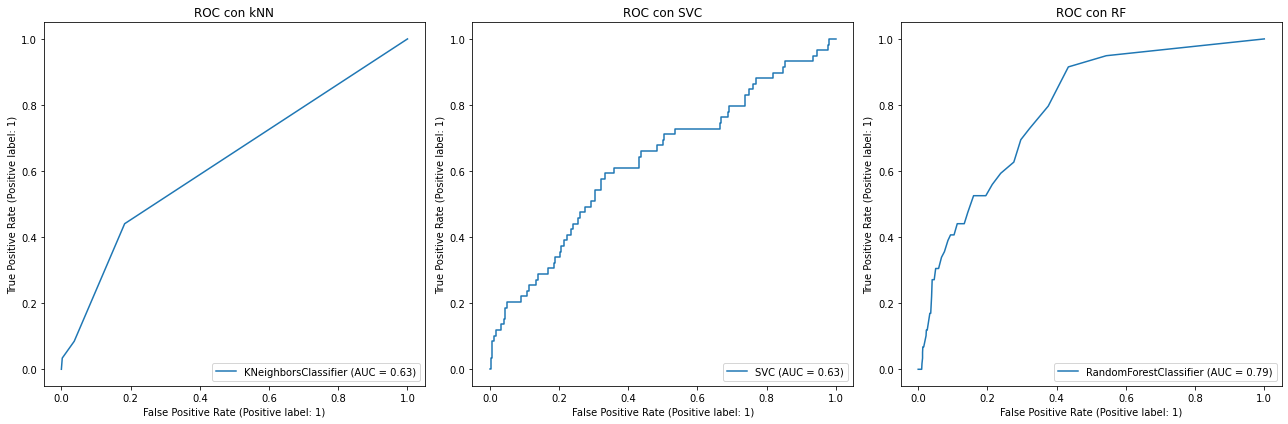

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18,6))

metrics.plot_roc_curve(clf_kNN, X_test, y_test, ax=ax1)
ax1.set_title('ROC con kNN') 
metrics.plot_roc_curve(clf_SVC, X_test, y_test, ax=ax2)
ax2.set_title('ROC con SVC') 
metrics.plot_roc_curve(clf_RF, X_test, y_test, ax=ax3) 
ax3.set_title('ROC con RF')

plt.tight_layout() 
plt.show()

# Balanceo del dataset

Los resultados mostrados anteriormente demuestran que los modelos logran predecir los casos sin ACV de manera óptima dado que cada modelo fue entrenado y testeado con una cantidad considerable de muestras. En cambio, a la hora de predecir los casos con ACV, todos los modelos fallan debido a la poca cantidad de muestras de entrenamiento y testeo.

Para solucionar este problema, se decide balancear el dataset generando nuevas muestras de casos con ACV para equiparar los números. Para dicha finalidad se utiliza la función SMOTE de la biblioteca Imbalance Learn.

In [ ]:
#balanceo
print('Original dataset shape {}'.format(Counter(y_train)))
sm = SMOTE(random_state=None)
X_new, y_new = sm.fit_resample(X, y)
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new, test_size=0.25, random_state=0)
print('New dataset shape {}'.format(Counter(y_train_new)))

#entreno los algoritmos

clf_kNN.fit(X_train_new, y_train_new)
clf_SVC.fit(X_train_new, y_train_new)
clf_RF.fit(X_train_new, y_train_new)

y_pred_kNN = clf_kNN.predict(X_test_new)
y_pred_SVC = clf_SVC.predict(X_test_new)
y_pred_RF = clf_RF.predict(X_test_new)



Original dataset shape Counter({0: 3546, 1: 189})
New dataset shape Counter({1: 3560, 0: 3539})


In [ ]:
kNN_score_cv = cross_val_score(clf_kNN, X_new, y_new, cv=5)
SVC_score_cv = cross_val_score(clf_SVC, X_new, y_new, cv=5)
RF_score_cv = cross_val_score(clf_RF, X_new, y_new, cv=5)

print("Accuracy para kNN: %0.3f (+/- %0.3f)" % (kNN_score_cv.mean(), kNN_score_cv.std() * 2))
print("Accuracy para SVC: %0.3f (+/- %0.3f)" % (SVC_score_cv.mean(), SVC_score_cv.std() * 2))
print("Accuracy para RF: %0.3f (+/- %0.3f)" % (RF_score_cv.mean(), RF_score_cv.std() * 2))

Accuracy para kNN: 0.905 (+/- 0.023)
Accuracy para SVC: 0.832 (+/- 0.013)
Accuracy para RF: 0.948 (+/- 0.021)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMa

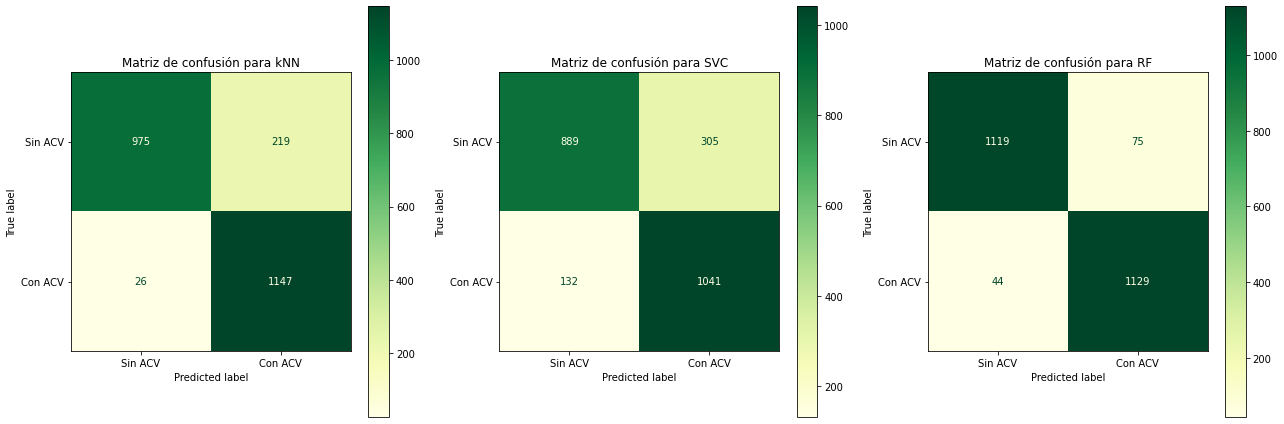

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18,6))

disp = plot_confusion_matrix(clf_kNN, X_test_new, y_test_new, display_labels=class_names,cmap = 'YlGn', ax=ax1)
disp.ax_.set_title("Matriz de confusión para kNN")

disp = plot_confusion_matrix(clf_SVC, X_test_new, y_test_new, display_labels=class_names, cmap = 'YlGn', ax=ax2)
disp.ax_.set_title("Matriz de confusión para SVC")

disp = plot_confusion_matrix(clf_RF, X_test_new, y_test_new, display_labels=class_names, cmap = 'YlGn', ax=ax3)
disp.ax_.set_title("Matriz de confusión para RF")

plt.tight_layout() 
plt.show()

In [ ]:
print('\n kNN REPORT')
print(classification_report(y_test_new, y_pred_kNN, target_names=class_names))
print('\n SVM REPORT')
print(classification_report(y_test_new, y_pred_SVC, target_names=class_names))
print('\n RANDOM FOREST REPORT')
print(classification_report(y_test_new, y_pred_RF, target_names=class_names))


 kNN REPORT
              precision    recall  f1-score   support

     Sin ACV       0.97      0.82      0.89      1194
     Con ACV       0.84      0.98      0.90      1173

    accuracy                           0.90      2367
   macro avg       0.91      0.90      0.90      2367
weighted avg       0.91      0.90      0.90      2367


 SVM REPORT
              precision    recall  f1-score   support

     Sin ACV       0.87      0.74      0.80      1194
     Con ACV       0.77      0.89      0.83      1173

    accuracy                           0.82      2367
   macro avg       0.82      0.82      0.81      2367
weighted avg       0.82      0.82      0.81      2367


 RANDOM FOREST REPORT
              precision    recall  f1-score   support

     Sin ACV       0.96      0.94      0.95      1194
     Con ACV       0.94      0.96      0.95      1173

    accuracy                           0.95      2367
   macro avg       0.95      0.95      0.95      2367
weighted avg       0.95  

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. U

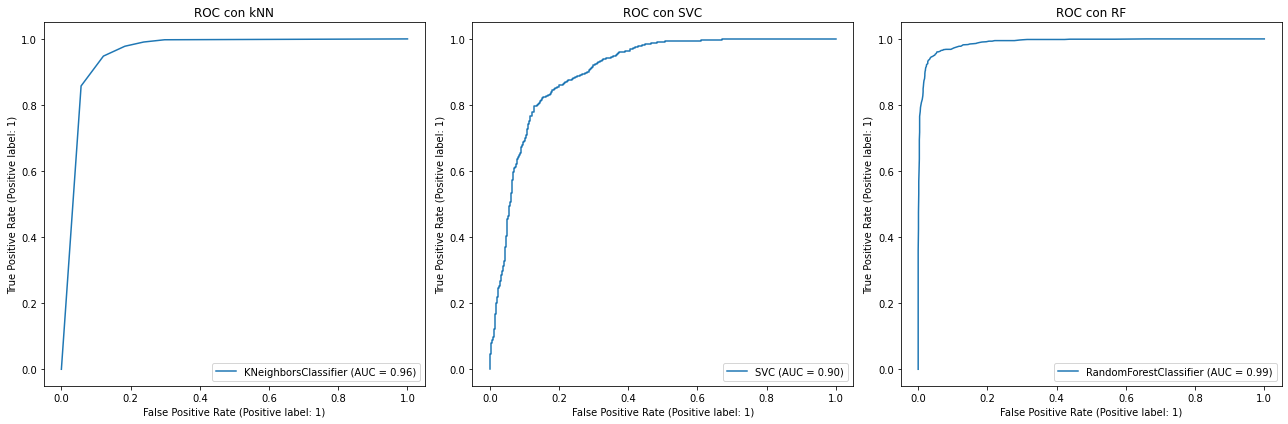

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18,6))

metrics.plot_roc_curve(clf_kNN, X_test_new, y_test_new, ax=ax1)
ax1.set_title('ROC con kNN') 
metrics.plot_roc_curve(clf_SVC, X_test_new, y_test_new, ax=ax2)
ax2.set_title('ROC con SVC') 
metrics.plot_roc_curve(clf_RF, X_test_new, y_test_new, ax=ax3) 
ax3.set_title('ROC con RF')

plt.tight_layout() 
plt.show()

Al haber balanceado la muestra ahora tanto los análisis estadísticos como los gráficos de ROC demuestran que los tres modelos logran predecir mejor los casos con ACV. 

Al analizar todos los resultados presentados, se puede ver que:


*   La matriz de confusión para el modelo de Random Forest es la que tiene mayor número de muestras predichas correctamente
*   Al hacer el cálculo de análisis de precisión con varios grupos y el reporte de clasificación, Random Forest es el que tiene mayor media
*   El gráfico de ROC para Random Forest es el que da un área debajo de la curva más cercano a 1

Al ser el más efectivo de los tres, se decide ajustar los hiperparámetros con el modelo Random Forest y así buscar un modelo óptimo. 

# Ajuste de hiperparámetros para Random Forest

Los resultados vistos hasta recién se obtuvieron con los valores default de la biblioteca Scikit-Learn de Python. Para lograr una mejor predicción, se modificará el modelo con distintos parámetros. Inicialmente se utiliza el algoritmo de *Halving Random*. 

In [ ]:
np.random.seed(0)
param_distributions = {"max_depth": [5, None], "min_samples_split": randint(2, 20), "n_estimators": randint(50,200)}
search = HalvingRandomSearchCV(clf_RF, param_distributions, max_resources=30, random_state=0).fit(X_new, y_new)
par=search.best_params_
print(par)

{'max_depth': 5, 'min_samples_split': 17, 'n_estimators': 167}


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


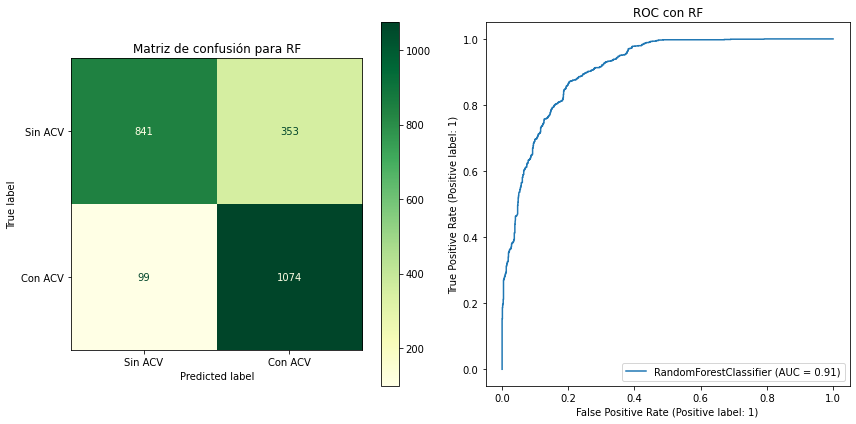


Accuracy para RF: 0.815 (+/- 0.007)

 RANDOM FOREST REPORT
              precision    recall  f1-score   support

     Sin ACV       0.89      0.70      0.79      1194
     Con ACV       0.75      0.92      0.83      1173

    accuracy                           0.81      2367
   macro avg       0.82      0.81      0.81      2367
weighted avg       0.82      0.81      0.81      2367



In [ ]:
clf_RF_new = RandomForestClassifier(max_depth=par["max_depth"], min_samples_split=par["min_samples_split"], n_estimators=par["n_estimators"], random_state=0)

clf_RF_new.fit(X_train_new, y_train_new)

y_pred_RF_new = clf_RF_new.predict(X_test_new)


fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
disp = plot_confusion_matrix(clf_RF_new, X_test_new, y_test_new, display_labels=class_names, cmap = 'YlGn', ax=ax1)
disp.ax_.set_title("Matriz de confusión para RF")

metrics.plot_roc_curve(clf_RF_new, X_test_new, y_test_new, ax=ax2)
ax2.set_title('ROC con RF') 
plt.tight_layout() 
plt.show()

RF_score_cv = cross_val_score(clf_RF_new, X_new, y_new, cv=5)
print("\nAccuracy para RF: %0.3f (+/- %0.3f)" % (RF_score_cv.mean(), RF_score_cv.std() * 2))

print('\n RANDOM FOREST REPORT')
print(classification_report(y_test_new, y_pred_RF_new, target_names=class_names))



Resulta evidente que al ajustar inicialmente algunos parámetros escogidos sin el suficiente criterio, el modelo empeora.

Se decidió entonces investigar que parámetros eran más relevantes al modelo y a partir de lo hallado en el [siguiente link](https://www.stat.berkeley.edu/~breiman/randomforest2001.pdf) se realizó un nuevo código. 

In [ ]:
# Numero de arboles en random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Numero de caracteristicas a considerar en cada division
max_features = ['auto', 'sqrt']
# Maxima profundidad del arbol
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimo numero de muestras requerido para dividir un nodo
min_samples_split = [2, 5, 10]
# Minimo numero de muestras requerido en cada nodo leaf
min_samples_leaf = [1, 2, 4]
# Metodo de seleccion de muestras para el entrenamiento de cada arbol
bootstrap = [True, False]
# Creacion del random grid
random_grid = {'n_estimators': n_estimators, 'max_features': max_features, 'max_depth': max_depth, 'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf, 'bootstrap': bootstrap}

search2 = RandomizedSearchCV(estimator = clf_RF, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=0, n_jobs = -1).fit(X_new, y_new)
par2=search2.best_params_
print(par2)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'n_estimators': 1600, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 100, 'bootstrap': False}


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


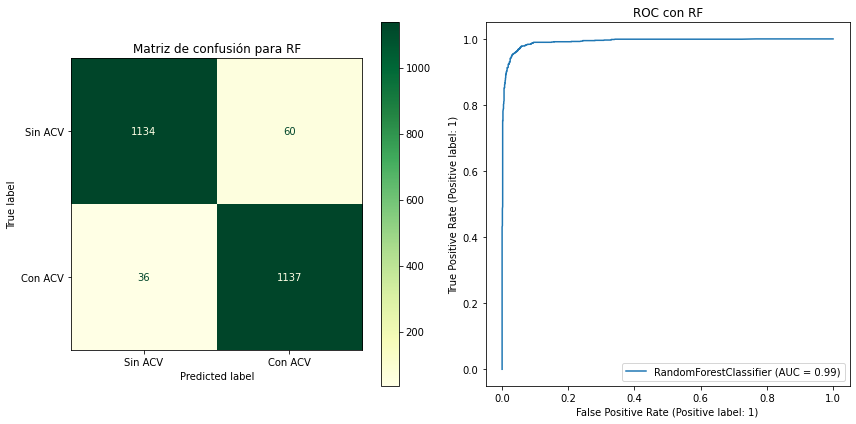


Accuracy para RF: 0.958 (+/- 0.025)

 RANDOM FOREST REPORT
              precision    recall  f1-score   support

     Sin ACV       0.97      0.95      0.96      1194
     Con ACV       0.95      0.97      0.96      1173

    accuracy                           0.96      2367
   macro avg       0.96      0.96      0.96      2367
weighted avg       0.96      0.96      0.96      2367



In [ ]:
clf_RF_new2 = RandomForestClassifier(max_depth=par2["max_depth"], min_samples_split=par2["min_samples_split"], n_estimators=par2['n_estimators'], max_features=par2['max_features'], min_samples_leaf=par2['min_samples_leaf'], bootstrap=par2['bootstrap'], random_state=0)

clf_RF_new2.fit(X_train_new, y_train_new)

y_pred_RF_new2 = clf_RF_new2.predict(X_test_new)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
disp = plot_confusion_matrix(clf_RF_new2, X_test_new, y_test_new, display_labels=class_names, cmap = 'YlGn', ax=ax1)
disp.ax_.set_title("Matriz de confusión para RF")

metrics.plot_roc_curve(clf_RF_new2, X_test_new, y_test_new, ax=ax2) 
ax2.set_title('ROC con RF')
plt.tight_layout() 
plt.show()

RF_score_cv = cross_val_score(clf_RF_new2, X_new, y_new, cv=5)
print("\nAccuracy para RF: %0.3f (+/- %0.3f)" % (RF_score_cv.mean(), RF_score_cv.std() * 2))

print('\n RANDOM FOREST REPORT')
print(classification_report(y_test_new, y_pred_RF_new2, target_names=class_names))

Finalmente se observan diversas mejoras en el modelo, entre ellas:

*   Un valor de *accuracy* de 96%
*   Una modificación muy favorable en cuanto a la curva ROC (con un área debajo de la curva de 0,99)
*   Una matriz de confusión que demuestra un incremento en las predicciones correctas 
*   Una mejora de entre 2 y 3% de los parámetros de precisión, *f1-score* y *recall* 







# Conclusiones

Se concluye que el objetivo de predecir ausencia o presencia de ACVs según las características del set de datos fue alcanzado con éxito.

Además, se observó que para una correcta predicción no sólo es necesario un buen algoritmo clasificador, sino también una base de datos adecuada. Resultó de vital importancia balancear el *data set* y buscar un modo de rellenar los valores faltantes, puesto que en caso contrario se hubiesen perdido alrededor de un 30% de las entradas. Luego, se halló que para el problema en cuestión el modelo que mejor se ajusta es el de *random forest*.

Por último, se vio que el algoritmo mejoró considerablemente cuando se modificaron sus hiperparámetros (profundidad máxima, número de estimadores, cantidad de elementos por división, entre otros).